# ResNet50 Skin Lesion CLassification

The project aims to develop a deep learning model for accurately classifying skin lesions into distinct categories, including melanoma, nevi, and benign lesions. Skin lesion classification is a critical task in dermatology, and automating this process using deep learning techniques can aid in early detection and improved patient outcomes.
Unlike standard datasets such as MNIST or CIFAR-10, which are limited in diversity, skin lesion classification presents challenges due to the variability and complexity of skin conditions.

The project utilizes the International Skin Imaging Collaboration (ISIC) dataset, which contains a diverse collection of dermatoscopic images encompassing various skin lesion types. The dataset is annotated with ground truth labels for lesion categories, providing a valuable resource for supervised learning tasks in skin lesion classification.

Dataset URL: https://challenge.isic-archive.com/data/

The version I have used it the 2016 version.


Task: Training a deep neural network to accurately classify skin lesions into predefined categories, including melanoma (malignant), nevi, and benign lesions. I will explore architectures such as ResNet, VGG,
or custom networks suitable for handling complex image features specific to dermatoscopic images. 
Data augmentation techniques such as rotation, flipping, scaling, and color jittering will be employed to improve model
generalization and robustness. The problem is a 2 class classification task given the labels of benign and malignant in the ground-truth files.


Relevant Papers:
1. Kassem, Mohamed A., et al.
"Machine learning and deep learning methods for skin lesion classification and
diagnosis: a systematic review.
" Diagnostics 11.8 (2021): 1390.
2. Lopez, Adria Romero, et al.
"Skin lesion classification from dermoscopic images using deep learning
techniques.
" 2017 13th IASTED international conference on biomedical engineering (BioMed). IEEE, 2017.
3. Benyahia, Samia, Boudjelal Meftah, and Olivier Lézoray.
lesion classification.
" Tissue and Cell 74 (2022): 101701.

### Installing the necessary libraries

In [1]:
%pip install torch torchvision torchmetrics pillow numpy pandas matplotlib seaborn scikit-learn tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Importing the Required Libraries

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Creating a Validation Set

As only a train set and test set are given to optimally get through to training the models on the correctly a validation set is required. Also ensuring that the val set is sized at 20% of the training set.

In [3]:
# Path to the original annotations file
annotations_file = 'training_data_classes.csv'

# Read the csv file
df = pd.read_csv(annotations_file, header=None, names=['filename', 'label'])

# 80% training, 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Save the splits
train_df.to_csv('train_split.csv', index=False, header=False)
val_df.to_csv('val_split.csv', index=False, header=False)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Training set size: 720
Validation set size: 180


### Dataset Class

Created a custom dataset class to handle the loading of the data (images) and its corresponding labels.

In [4]:
class DatasetClass(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_file, header=None, names=['filename', 'label'])
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.annotations.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = 1 if self.annotations.iloc[idx, 1] == 'malignant' else 0

        if self.transform:
            image = self.transform(image)

        return image, label


### Data Transformations

Due to the dataset only containing a limited number of images (900), I needed to perform data augmentation and normalisation on the training and validation datasets. 

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


### Data Loading

Loading the images correctly into the validation and training set

In [6]:
# Paths to the image directory and annotation files
train_images_dir = 'ISBI2016_ISIC_Part3_Training_Data'
train_annotations_file = 'train_split.csv'
val_annotations_file = 'val_split.csv'

# Create datasets for train set and val set
train_dataset = DatasetClass(train_images_dir, train_annotations_file, transform=data_transforms['train'])
val_dataset = DatasetClass(train_images_dir, val_annotations_file, transform=data_transforms['val'])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}


### Defining the Model

Here I am using the resnet50 model, it is an out of the box model that has pretrained weights. For this task I am using the Cross Entropy Loss function and the Adam optimiser. The final layer has been modified to better allow it to perform 2 class classification.

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load pre-trained ResNet-50 and modify the final layer
model = models.resnet50(pretrained=True)
numFeatures = model.fc.in_features
model.fc = nn.Linear(numFeatures, 2)  # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training and Validation Function

In [26]:
def train_and_validate_model(model, criterion, optimizer, dataloaders, num_epochs, save_path):
    best_model_wts = model.state_dict()
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_train_loss = 0.0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(dataloaders['train'])
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

        epoch_val_loss = running_val_loss / len(dataloaders['val'])
        val_losses.append(epoch_val_loss)

        print(f"Train Loss: {epoch_train_loss:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}")
        print()

        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with Validation Loss: {best_val_loss:.4f}")

    print("Training complete")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

### Running the Training & Validation Loop 

Epoch 1/50
Train Loss: 0.5680
Val Loss: 0.6152

Model saved with Validation Loss: 0.6152
Epoch 2/50
Train Loss: 0.5659
Val Loss: 0.6024

Model saved with Validation Loss: 0.6024
Epoch 3/50
Train Loss: 0.5627
Val Loss: 0.6011

Model saved with Validation Loss: 0.6011
Epoch 4/50
Train Loss: 0.5596
Val Loss: 0.5971

Model saved with Validation Loss: 0.5971
Epoch 5/50
Train Loss: 0.5693
Val Loss: 0.5954

Model saved with Validation Loss: 0.5954
Epoch 6/50
Train Loss: 0.5707
Val Loss: 0.6004

Epoch 7/50
Train Loss: 0.5709
Val Loss: 0.6023

Epoch 8/50
Train Loss: 0.5617
Val Loss: 0.6018

Epoch 9/50
Train Loss: 0.5633
Val Loss: 0.6005

Epoch 10/50
Train Loss: 0.5520
Val Loss: 0.5895

Model saved with Validation Loss: 0.5895
Epoch 11/50
Train Loss: 0.5698
Val Loss: 0.5936

Epoch 12/50
Train Loss: 0.5692
Val Loss: 0.5951

Epoch 13/50
Train Loss: 0.5755
Val Loss: 0.6026

Epoch 14/50
Train Loss: 0.5685
Val Loss: 0.6057

Epoch 15/50
Train Loss: 0.5742
Val Loss: 0.6016

Epoch 16/50
Train Loss: 0.56

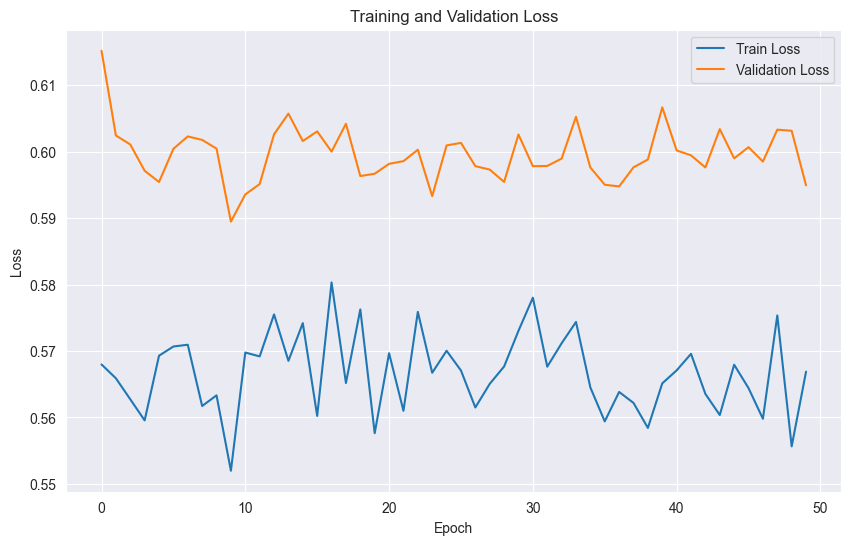

In [27]:
model = train_and_validate_model(model, criterion, optimizer, dataloaders, num_epochs=50, save_path='best_resnet50_model.pth')

### Dataset Class for Test Data

In [28]:
class TestDataClass(Dataset):
    def __init__(self, images_dir, annotations_file, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_file, header=None, names=['filename', 'label'])
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.annotations.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label, img_name

### Test Data Transformations

In [29]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Data Loader for Test Set

In [30]:
test_images_dir = 'ISBI2016_ISIC_Part3_Test_Data'
test_label_file = 'test_data_classes.txt'

test_dataset = TestDataClass(test_images_dir, test_label_file, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Test Function

In [31]:
import random


def test_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels, img_names in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Display image from the batch chosen at random
            idx = random.randint(0, len(inputs) - 1)
            img = inputs[idx].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalisation
            plt.imshow(img)
            plt.title(f"Predicted: {'Malignant' if preds[idx] == 1 else 'Benign'} | "
                      f"True: {'Malignant' if labels[idx] == 1 else 'Benign'}")
            plt.axis('off')
            plt.show()
            break  # Show one image

    # Classification report
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### Run the Test Loop

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/0z/0r2zwmkj2_540_2z_fbvq9740000gn/T/ipykernel_60883/2588810412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models fo

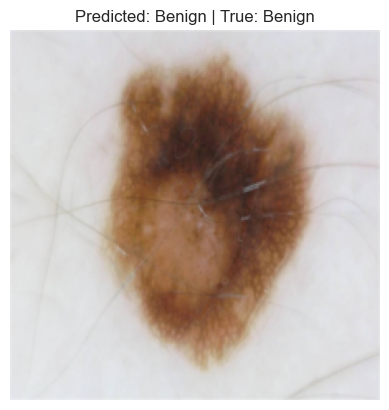

              precision    recall  f1-score   support

      Benign       0.62      1.00      0.77        10
   Malignant       0.00      0.00      0.00         6

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg       0.39      0.62      0.48        16



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

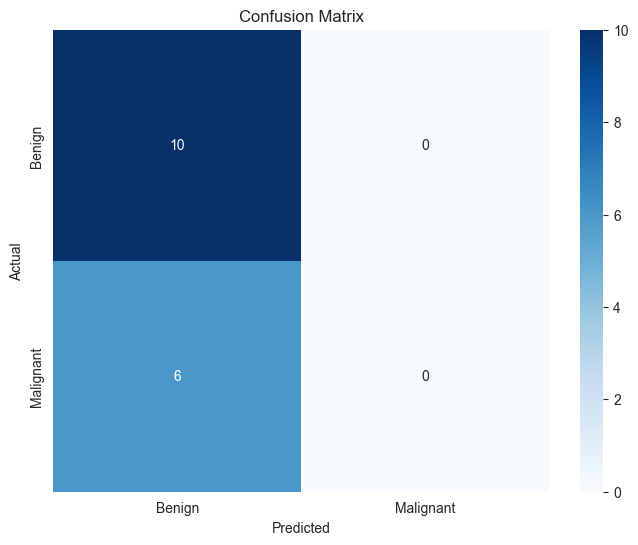

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 classes: benign and malignant
model.load_state_dict(torch.load('best_resnet50_model.pth', map_location=device))
model = model.to(device)

test_model(model, test_loader)